### Initial project set up.

In [3]:
# Install necesaries dependencies and modules.
import pandas as pd
import requests
import matplotlib.pyplot as plt

# Import API Key from config file. 
from config import API_KEY

In [4]:
# Function to fetch data from Nasdaq API.

def fetch_stock_data(symbol, api_key):
    url = f"https://data.nasdaq.com/api/v3/datasets/WIKI/{symbol}.json"
    params = {
        'api_key': api_key
    }
    response = requests.get(url, params=params)
    data = response.json()
    return pd.DataFrame(data['dataset']['data'], columns=data['dataset']['column_names'])

### Data fetching codes by industry: Telecom - Oil.

In [5]:
# Fetch data for Exxon Mobile, Chevron, and ConocoPhillips for Oil Stocks Analysis.
oil_symbols = {
    'Exxon Mobile': 'XOM',
    'Chevron': 'CVX',
    'ConocoPhillips': 'COP'
}

oil_stock_data = {}
for company, oil_symbol in oil_symbols.items():
    oil_stock_data[company] = fetch_stock_data(oil_symbol, API_KEY)

# Combine the data into a single DataFrame.
combined_oil_data = pd.concat(oil_stock_data.values(), keys=oil_stock_data.keys())
combined_oil_data.reset_index(level=0, inplace=True)
combined_oil_data.rename(columns={'level_0': 'Company'}, inplace=True)

In [6]:
# Fetch data for AT&T, T-Mobile, and Verizon for Telecom Stock Analysis.
tele_symbols = {
    'AT&T': 'T',
    'T-Mobile': 'TMUS',
    'Verizon': 'VZ'
}

stock_data = {}
for company, tele_symbol in tele_symbols.items():
    stock_data[company] = fetch_stock_data(tele_symbol, API_KEY)

# Combine the data into a single DataFrame for analysis
combined_tele_data = pd.concat(stock_data.values(), keys=stock_data.keys())
combined_tele_data.reset_index(level=0, inplace=True)
combined_tele_data.rename(columns={'level_0': 'Company'}, inplace=True)

### Data Cleaning and Organization.

In [7]:
# Convert the Tele Date column to datetime format
combined_tele_data['Date'] = pd.to_datetime(combined_tele_data['Date'])

# Sort the data by Company and Date
combined_tele_data.sort_values(by=['Company', 'Date'], inplace=True)

# Handle missing values (if any)
combined_tele_data.ffill(inplace=True)
combined_tele_data.bfill(inplace=True)

# Filter the data to include only dates from 2017-01-01 to 2017-12-12
start_date = pd.Timestamp('2017-01-01')
end_date = pd.Timestamp('2017-12-12')
filtered_tele_data = combined_tele_data[(combined_tele_data['Date'] >= start_date) & (combined_tele_data['Date'] <= end_date)].copy()

# Extract year and quarter
filtered_tele_data['Year'] = filtered_tele_data['Date'].dt.year
filtered_tele_data['Quarter'] = filtered_tele_data['Date'].dt.to_period('Q')

# Define the colors for each company
tele_colors = {'AT&T': 'Deepskyblue', 'T-Mobile': 'Fuchsia', 'Verizon': 'Crimson'}

# Save the cleaned and filtered Telecom data to a CSV file
filtered_tele_data.to_csv('outputs/filtered_tele_data.csv', index=False)


In [8]:
# Column creation and filtering for further analysis on Oil Data.

# Convert the Oil Date column to datetime format
combined_oil_data['Date'] = pd.to_datetime(combined_oil_data['Date'])

# Sort the data by Company and Date
combined_oil_data.sort_values(by=['Company', 'Date'], inplace=True)

# Handle missing values (if any)
combined_oil_data.ffill(inplace=True)
combined_oil_data.bfill(inplace=True)

# Filter the data to include only dates from 2017-01-01 to 2017-12-12
start_date = pd.Timestamp('2017-01-01')
end_date = pd.Timestamp('2017-12-12')
filtered_oil_data = combined_oil_data[(combined_oil_data['Date'] >= start_date) & (combined_oil_data['Date'] <= end_date)].copy()

# Extract year and quarter
filtered_oil_data['Year'] = filtered_oil_data['Date'].dt.year
filtered_oil_data['Quarter'] = filtered_oil_data['Date'].dt.to_period('Q')

# Define the colors for each company
oil_colors = {'Exxon Mobile': 'Red', 'Chevron': 'Blue', 'ConocoPhillips': 'Orange'}

# Save the cleaned and filtered Oil data to a CSV file
filtered_oil_data.to_csv('outputs/filtered_oil_data.csv', index=False)

### Stock Analysis.

### Percentage Change calculation: Measures the growth or decline in stock prices over a period, helping to identify trends and compare performance across different time frames.

C:\Users\Juanb\AppData\Local\Temp\ipykernel_1376\3235044929.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  quarterly_oil_percentage_change = filtered_oil_data.groupby(['Company', 'Quarter'], as_index=False).apply(


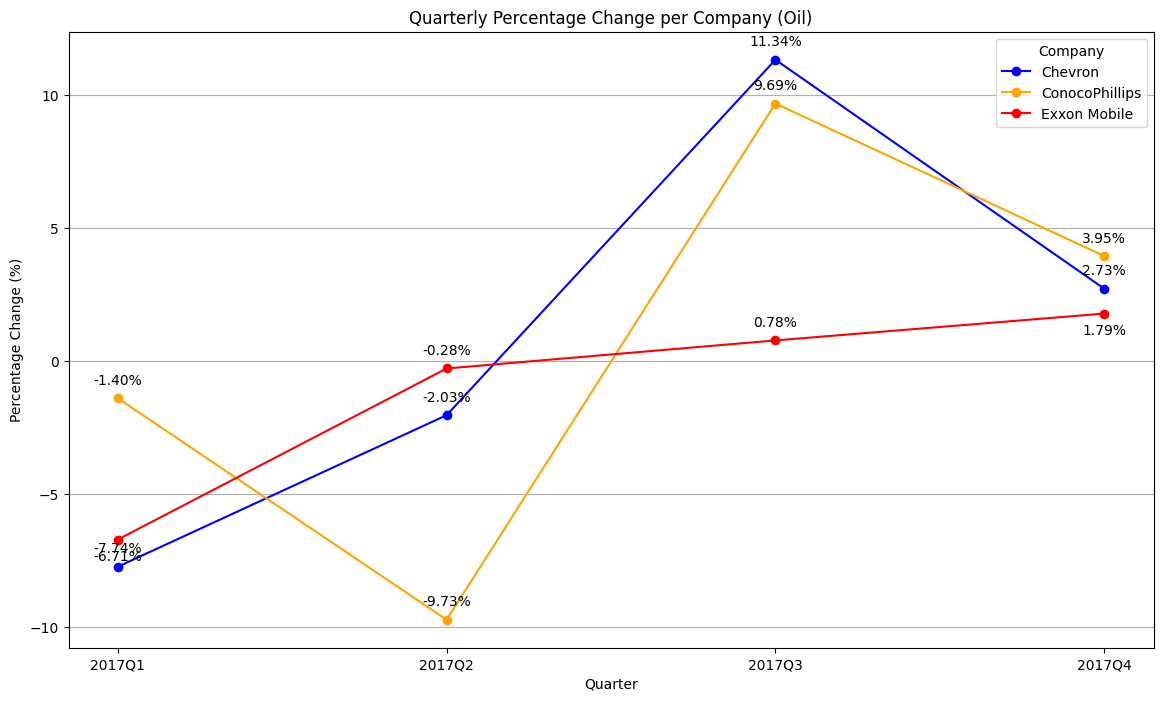

In [9]:
# Calculate the percentage change in Oil Stock for each quarter
quarterly_oil_percentage_change = filtered_oil_data.groupby(['Company', 'Quarter'], as_index=False).apply(
    lambda x: pd.Series({
        'Percentage Change': (x.loc[x['Date'].idxmax()]['Adj. Open'] - x.loc[x['Date'].idxmin()]['Adj. Close']) / x.loc[x['Date'].idxmin()]['Adj. Close'] * 100
    })
)
# Convert the 'Quarter' column to string due to formatting error.
quarterly_oil_percentage_change['Quarter'] = quarterly_oil_percentage_change['Quarter'].astype(str)

# Define the colors for each company
oil_colors = {'Exxon Mobile': 'Red', 'Chevron': 'Blue', 'ConocoPhillips': 'Orange'}

# Plot the quarterly percentage change.
plt.figure(figsize=(14, 8))
for company in quarterly_oil_percentage_change['Company'].unique():
    company_data = quarterly_oil_percentage_change[quarterly_oil_percentage_change['Company'] == company]
    plt.plot(company_data['Quarter'].astype(str), company_data['Percentage Change'], marker='o', label=company, color=oil_colors[company])
    # Annotate each percentage change by stock per quarter.
    for i, row in company_data.iterrows():
        if company == 'Exxon Mobile' and row['Quarter'] in ['2017Q1', '2017Q4']:
            plt.annotate(f"{row['Percentage Change']:.2f}%", (row['Quarter'], row['Percentage Change']), textcoords="offset points",
                         xytext=(0,-15), ha='center')  # Lower the annotation for Exxon in Q1 and Q4
        else:
            plt.annotate(f"{row['Percentage Change']:.2f}%", (row['Quarter'], row['Percentage Change']), textcoords="offset points",
                         xytext=(0,10), ha='center')

# Plot visual formatting.
plt.title('Quarterly Percentage Change per Company (Oil)')
plt.xlabel('Quarter')
plt.ylabel('Percentage Change (%)')
plt.legend(title='Company')
plt.grid(axis='y')
plt.savefig('outputs/oil_stock_change.png')
plt.show()

C:\Users\Juanb\AppData\Local\Temp\ipykernel_1376\249330759.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  quarterly_tele_percentage_change = filtered_tele_data.groupby(['Company', 'Quarter'], as_index=False).apply(


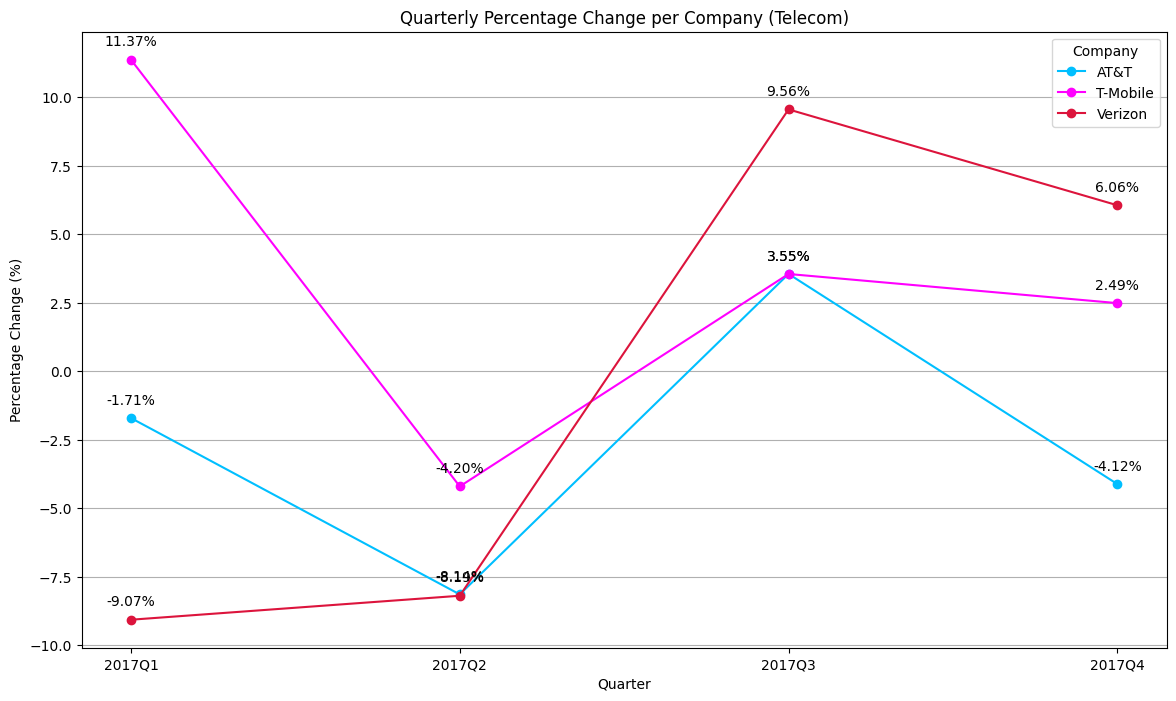

In [10]:
# Calculate the percentage change in Telecom Stock for each quarter
quarterly_tele_percentage_change = filtered_tele_data.groupby(['Company', 'Quarter'], as_index=False).apply(
    lambda x: pd.Series({
        'Percentage Change': (x.loc[x['Date'].idxmax()]['Adj. Open'] - x.loc[x['Date'].idxmin()]['Adj. Close']) / x.loc[x['Date'].idxmin()]['Adj. Close'] * 100
    })
)
# Convert the 'Quarter' column to string due to formatting error.
quarterly_tele_percentage_change['Quarter'] = quarterly_tele_percentage_change['Quarter'].astype(str)

# Define the colors for each company
tele_colors = {'AT&T': 'Deepskyblue', 'T-Mobile': 'Fuchsia', 'Verizon': 'Crimson'}

# Plot the quarterly percentage change.
plt.figure(figsize=(14, 8))
for company in quarterly_tele_percentage_change['Company'].unique():
    company_data = quarterly_tele_percentage_change[quarterly_tele_percentage_change['Company'] == company]
    plt.plot(company_data['Quarter'].astype(str), company_data['Percentage Change'], marker='o', label=company, color=tele_colors[company])
    # Annotate each percentage change by stock per quarter.
    for i, row in company_data.iterrows():
        plt.annotate(f"{row['Percentage Change']:.2f}%", (row['Quarter'], row['Percentage Change']), textcoords="offset points",
                     xytext=(0,10), ha='center')

# Plot visual formatting.
plt.title('Quarterly Percentage Change per Company (Telecom)')
plt.xlabel('Quarter')
plt.ylabel('Percentage Change (%)')
plt.legend(title='Company')
plt.grid(axis='y')
plt.savefig('outputs/telecom_stock_change.png')
plt.show()


### Stock Volume Change: Indicates the trading activity and liquidity of a stock, reflecting investor interest and potential price movements.

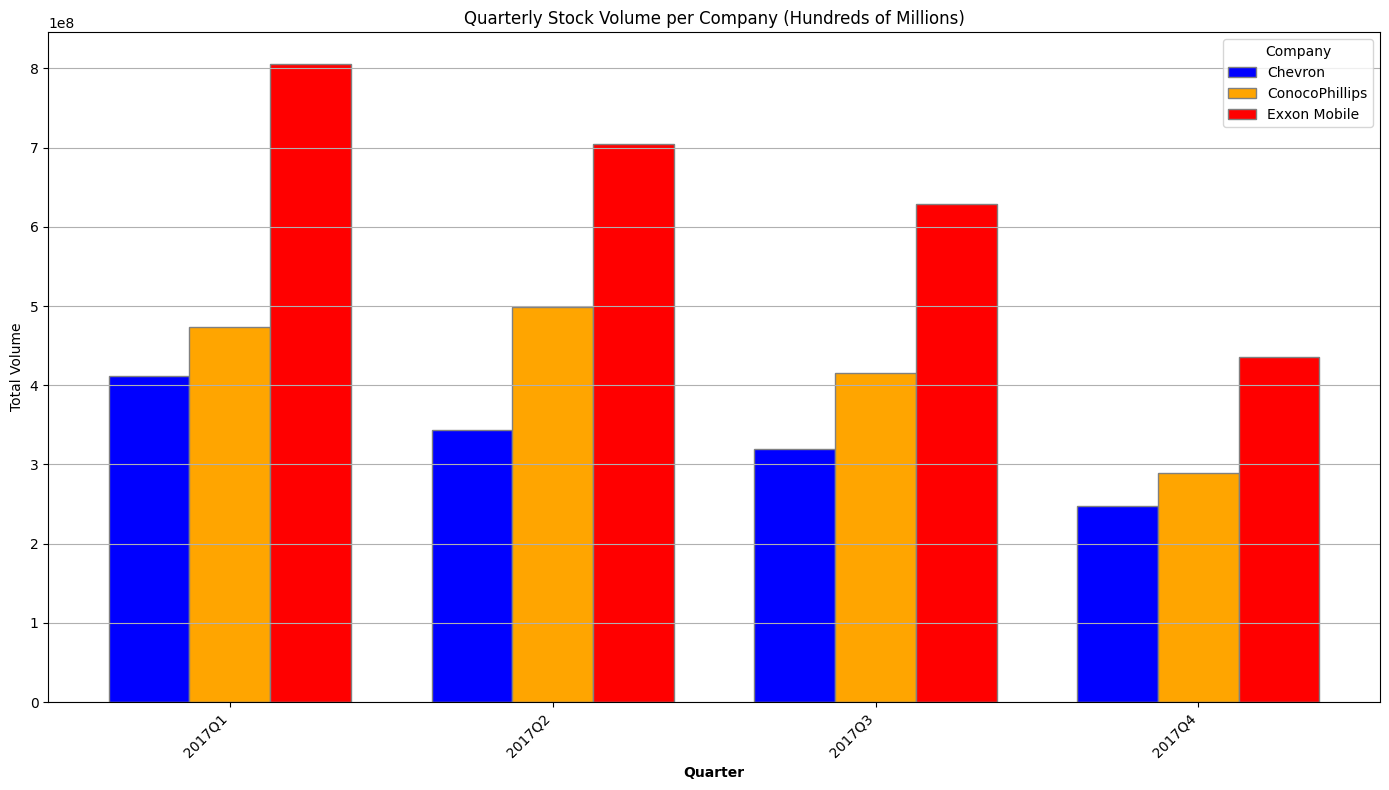

,Company,Quarter,Volume
0,Chevron,2017Q1,411821655.0
1,Chevron,2017Q2,342933559.0
2,Chevron,2017Q3,318949391.0
3,Chevron,2017Q4,247892648.0
4,ConocoPhillips,2017Q1,473859472.0
5,ConocoPhillips,2017Q2,499307686.0
6,ConocoPhillips,2017Q3,415452575.0
7,ConocoPhillips,2017Q4,289125986.0
8,Exxon Mobile,2017Q1,805398170.0
9,Exxon Mobile,2017Q2,705036084.0


In [11]:
# Calculate the quarterly Oil Stock Volume change per quarter.
quarterly_oil_volume = filtered_oil_data.groupby(['Company', 'Quarter'], as_index=False).agg({
    'Volume': 'sum'
})

# Convert the Quarter to a string for plotting due to compiling error.
quarterly_oil_volume['Quarter'] = quarterly_oil_volume['Quarter'].astype(str)

# Get unique quarters and companies
unique_quarters = quarterly_oil_volume['Quarter'].unique()
unique_companies = quarterly_oil_volume['Company'].unique()

# Set the width of the bars
bar_width = 0.25

# Set the position of the bars on the x-axis
r1 = range(len(unique_quarters))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plot the bars
plt.figure(figsize=(14, 8))

for i, company in enumerate(unique_companies):
    company_data = quarterly_oil_volume[quarterly_oil_volume['Company'] == company]
    positions = [x + i * bar_width for x in r1]
    plt.bar(positions, company_data['Volume'], width=bar_width, edgecolor='grey', label=company, color=oil_colors[company])

# Plot visual formatting.
# Add xticks on the middle of the group bars
plt.xlabel('Quarter', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(unique_quarters))], unique_quarters)

plt.title('Quarterly Stock Volume per Company (Hundreds of Millions)')
plt.ylabel('Total Volume')
plt.legend(title='Company')
plt.grid(axis='y')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('outputs/oil_stock_volume.png')
plt.show()

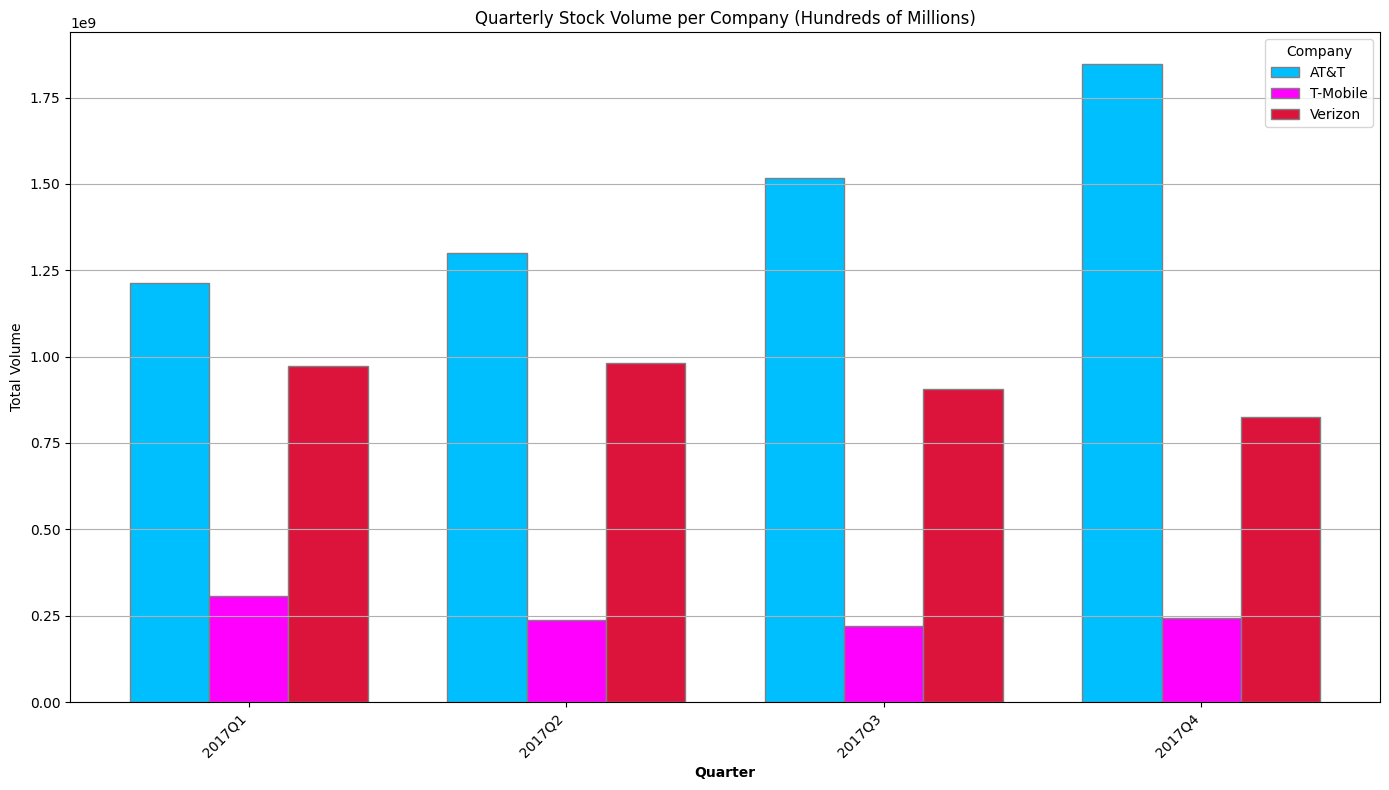

,Company,Quarter,Volume
0,AT&T,2017Q1,1.213246e+09
1,AT&T,2017Q2,1.300602e+09
2,AT&T,2017Q3,1.518243e+09
3,AT&T,2017Q4,1.846553e+09
4,T-Mobile,2017Q1,3.066997e+08
5,T-Mobile,2017Q2,2.375184e+08
6,T-Mobile,2017Q3,2.204270e+08
7,T-Mobile,2017Q4,2.418094e+08
8,Verizon,2017Q1,9.722799e+08
9,Verizon,2017Q2,9.810560e+08


In [17]:
# Calculate the quarterly tele Stock Volume change per quarter.
quarterly_tele_volume = filtered_tele_data.groupby(['Company', 'Quarter'], as_index=False).agg({
    'Volume': 'sum'
})

# Convert the Quarter to a string for plotting due to compiling error.
quarterly_tele_volume['Quarter'] = quarterly_tele_volume['Quarter'].astype(str)

# Get unique quarters and companies
unique_quarters = quarterly_tele_volume['Quarter'].unique()
unique_companies = quarterly_tele_volume['Company'].unique()

# Set the width of the bars
bar_width = 0.25

# Set the position of the bars on the x-axis
r1 = range(len(unique_quarters))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plot the bars
plt.figure(figsize=(14, 8))

for i, company in enumerate(unique_companies):
    company_data = quarterly_tele_volume[quarterly_tele_volume['Company'] == company]
    positions = [x + i * bar_width for x in r1]
    plt.bar(positions, company_data['Volume'], width=bar_width, edgecolor='grey', label=company, color=tele_colors[company])

# Plot visual formatting.
# Add xticks on the middle of the group bars
plt.xlabel('Quarter', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(unique_quarters))], unique_quarters)

plt.title('Quarterly Stock Volume per Company (Hundreds of Millions)')
plt.ylabel('Total Volume')
plt.legend(title='Company')
plt.grid(axis='y')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('outputs/tele_stock_volume.png')
plt.show()


### Standard Deviation (Volatility): Assesses the risk associated with a stock by measuring the variability of its returns, aiding in risk management and investment decisions.

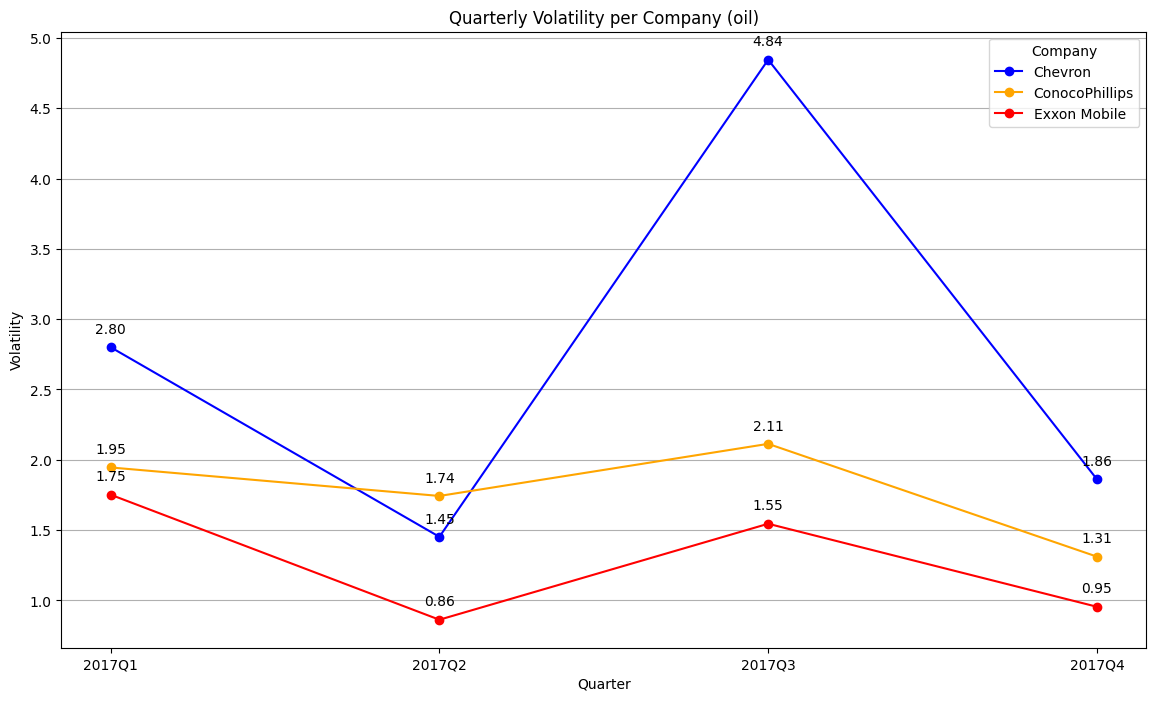

,Company,Quarter,Volatility
0,Chevron,2017Q1,2.800641
1,Chevron,2017Q2,1.452246
2,Chevron,2017Q3,4.844584
3,Chevron,2017Q4,1.861172
4,ConocoPhillips,2017Q1,1.945490
5,ConocoPhillips,2017Q2,1.742819
6,ConocoPhillips,2017Q3,2.113314
7,ConocoPhillips,2017Q4,1.311316
8,Exxon Mobile,2017Q1,1.751825
9,Exxon Mobile,2017Q2,0.862795


In [18]:
# Calculate the standard deviation (volatility) in oil Stock for each quarter
quarterly_oil_volatility = filtered_oil_data.groupby(['Company', 'Quarter'], as_index=False)['Adj. Close'].std()
quarterly_oil_volatility.rename(columns={'Adj. Close': 'Volatility'}, inplace=True)

# Convert the 'Quarter' column to string due to formatting error.
quarterly_oil_volatility['Quarter'] = quarterly_oil_volatility['Quarter'].astype(str)

# Plot the quarterly volatility.
plt.figure(figsize=(14, 8))
for company in quarterly_oil_volatility['Company'].unique():
    company_data = quarterly_oil_volatility[quarterly_oil_volatility['Company'] == company]
    plt.plot(company_data['Quarter'].astype(str), company_data['Volatility'], marker='o', label=company, color=oil_colors[company])
    # Annotate each volatility by stock per quarter.
    for i, row in company_data.iterrows():
        plt.annotate(f"{row['Volatility']:.2f}", (row['Quarter'], row['Volatility']), textcoords="offset points",
                     xytext=(0,10), ha='center')

# Plot visual formatting.
plt.title('Quarterly Volatility per Company (oil)')
plt.xlabel('Quarter')
plt.ylabel('Volatility')
plt.legend(title='Company')
plt.grid(axis='y')
plt.savefig('outputs/oil_volatility.png')
plt.show()

quarterly_oil_volatility

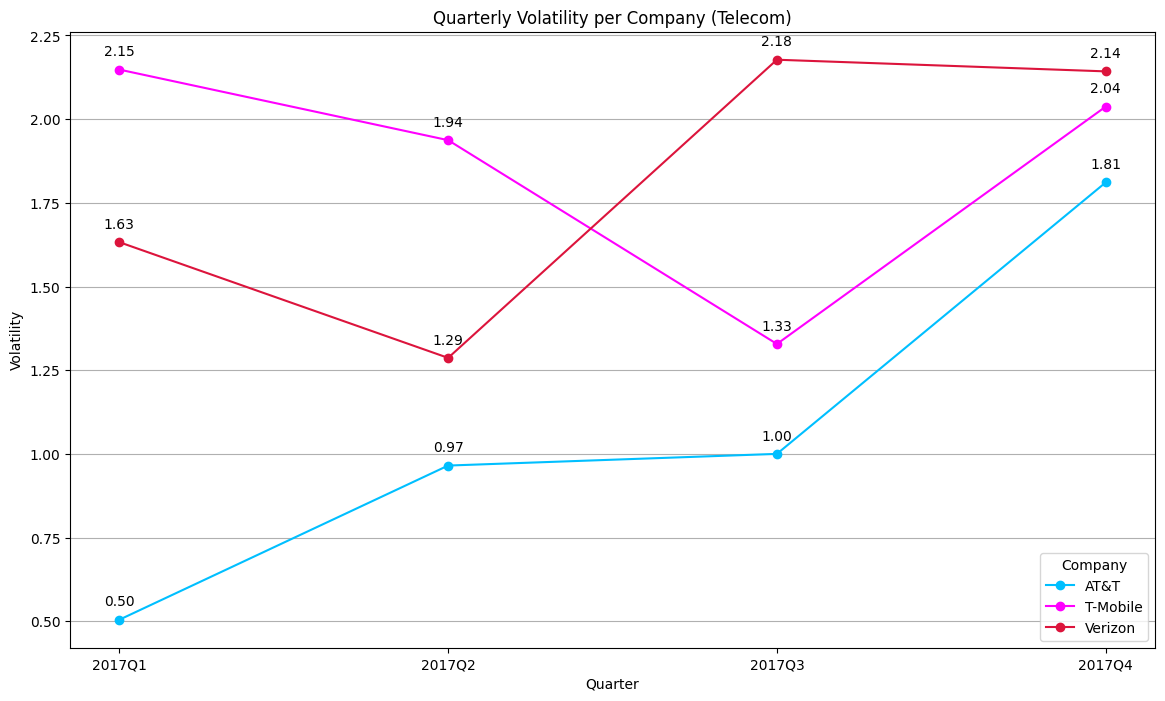

,Company,Quarter,Volatility
0,AT&T,2017Q1,0.504929
1,AT&T,2017Q2,0.965365
2,AT&T,2017Q3,1.000266
3,AT&T,2017Q4,1.811021
4,T-Mobile,2017Q1,2.147990
5,T-Mobile,2017Q2,1.937203
6,T-Mobile,2017Q3,1.328478
7,T-Mobile,2017Q4,2.037394
8,Verizon,2017Q1,1.632526
9,Verizon,2017Q2,1.286965


In [19]:
# Calculate the standard deviation (volatility) in Telecom Stock for each quarter
quarterly_tele_volatility = filtered_tele_data.groupby(['Company', 'Quarter'], as_index=False)['Adj. Close'].std()
quarterly_tele_volatility.rename(columns={'Adj. Close': 'Volatility'}, inplace=True)

# Convert the 'Quarter' column to string due to formatting error.
quarterly_tele_volatility['Quarter'] = quarterly_tele_volatility['Quarter'].astype(str)

# Plot the quarterly volatility.
plt.figure(figsize=(14, 8))
for company in quarterly_tele_volatility['Company'].unique():
    company_data = quarterly_tele_volatility[quarterly_tele_volatility['Company'] == company]
    plt.plot(company_data['Quarter'].astype(str), company_data['Volatility'], marker='o', label=company, color=tele_colors[company])
    # Annotate each volatility by stock per quarter.
    for i, row in company_data.iterrows():
        plt.annotate(f"{row['Volatility']:.2f}", (row['Quarter'], row['Volatility']), textcoords="offset points",
                     xytext=(0,10), ha='center')

# Plot visual formatting.
plt.title('Quarterly Volatility per Company (Telecom)')
plt.xlabel('Quarter')
plt.ylabel('Volatility')
plt.legend(title='Company')
plt.grid(axis='y')
plt.savefig('outputs/telecom_volatility.png')
plt.show()

quarterly_tele_volatility

### Return on Investment (ROI): Evaluates the profitability of an investment, enabling investors to gauge the efficiency of their investment choices and compare different investment opportunities.

C:\Users\Juanb\AppData\Local\Temp\ipykernel_1376\1413105412.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  quarterly_oil_roi = filtered_oil_data.groupby(['Company', 'Quarter']).apply(oil_roi).reset_index()


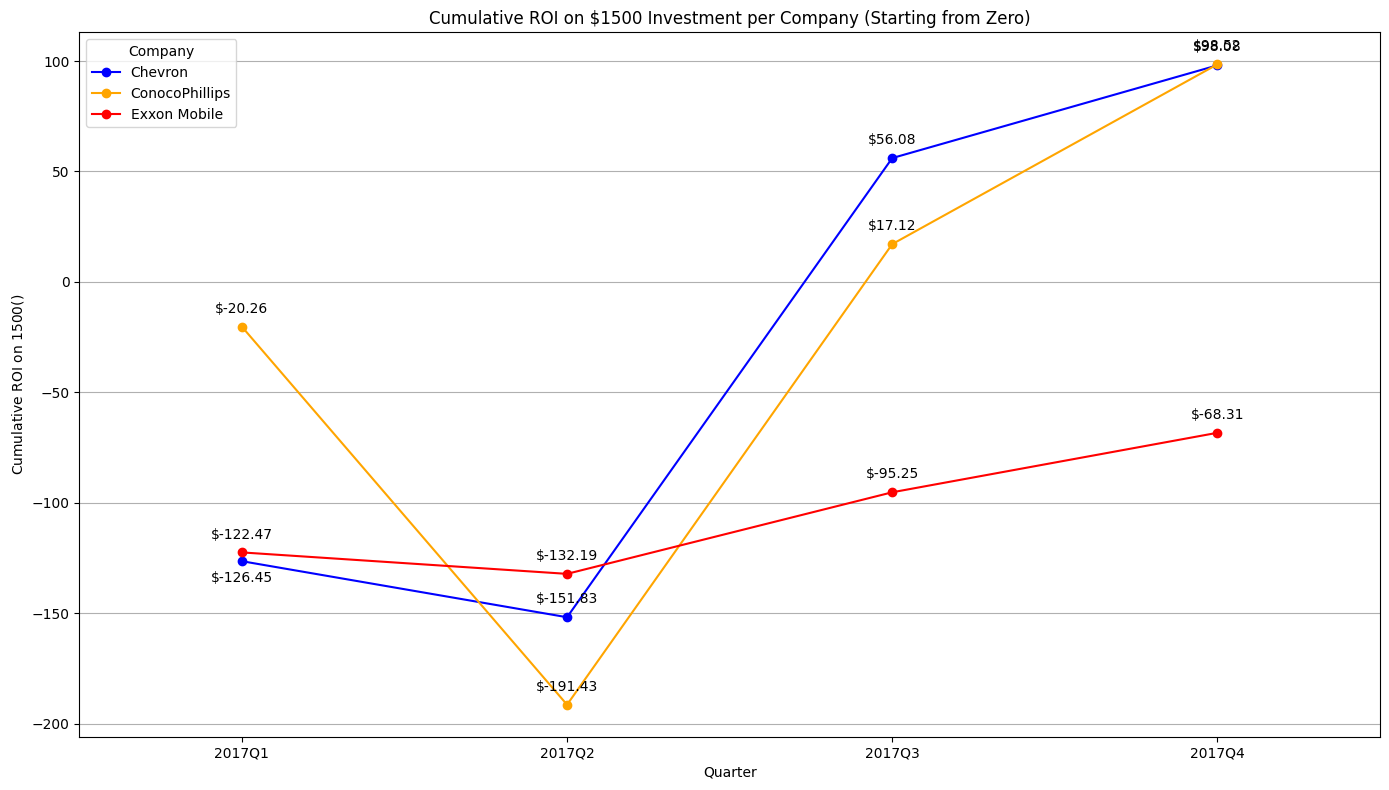

In [15]:
# Get the opening price on 2017-01-03 for each company
initial_prices = filtered_oil_data[filtered_oil_data['Date'] == pd.Timestamp('2017-01-03')].set_index('Company')['Adj. Open']

# Calculate the ROI based on quarter opening and closing prices of the Oil Stocks Data
def oil_roi(group):
    opening_price = group.iloc[0]['Adj. Open']
    closing_price = group.iloc[-1]['Adj. Close']
    roi_percentage = ((closing_price - opening_price) / opening_price) * 100
    return pd.Series({
        'Quarter ROI (%)': roi_percentage,
        'ROI on $1500 ($)': (roi_percentage / 100) * 1500
    })

# Apply the ROI calculation to each company for each quarter
quarterly_oil_roi = filtered_oil_data.groupby(['Company', 'Quarter']).apply(oil_roi).reset_index()

# Initialize cumulative ROI with zero
initial_investment = pd.DataFrame({
    'Company': initial_prices.index,
    'Quarter': '0',
    'Quarter ROI (%)': 0,
    'ROI on $1500 ($)': 0,
    'Cumulative ROI on $1500 ($)': 0
})

# Ensure that the cumulative ROI starts from zero for each company
quarterly_oil_roi['Cumulative ROI on $1500 ($)'] = quarterly_oil_roi.groupby('Company')['ROI on $1500 ($)'].cumsum()
quarterly_oil_roi = pd.concat([initial_investment, quarterly_oil_roi], ignore_index=True).sort_values(by=['Company', 'Quarter'])

# Convert the 'Quarter' column to string
quarterly_oil_roi['Quarter'] = quarterly_oil_roi['Quarter'].astype(str)

# Remove the final zero point at the end for each company
quarterly_oil_roi = quarterly_oil_roi[quarterly_oil_roi['Quarter'] != '0']

# Plot the cumulative ROI on a $1500 investment starting from zero
plt.figure(figsize=(14, 8))

for company in quarterly_oil_roi['Company'].unique():
    company_data = quarterly_oil_roi[quarterly_oil_roi['Company'] == company]
    plt.plot(company_data['Quarter'].astype(str), company_data['Cumulative ROI on $1500 ($)'], marker='o', label=company, color=oil_colors[company])

    # Annotate each point with the Y value
    for i, row in company_data.iterrows():
        if company == 'Chevron' and row['Quarter'] == '2017Q1':
            plt.annotate(f"${row['Cumulative ROI on $1500 ($)']:.2f}", (row['Quarter'], row['Cumulative ROI on $1500 ($)']), textcoords="offset points",
                         xytext=(0, -15), ha='center')  # Lower the annotation for Chevron in Q1
        else:
            plt.annotate(f"${row['Cumulative ROI on $1500 ($)']:.2f}", (row['Quarter'], row['Cumulative ROI on $1500 ($)']), textcoords="offset points",
                         xytext=(0, 10), ha='center')

# Plot visual formatting.
# Define the x-tick positions and labels
xticks_positions = range(len(quarterly_oil_roi['Quarter'].unique()))
xticks_labels = ['2017Q1', '2017Q2', '2017Q3', '2017Q4']

plt.xticks(xticks_positions, xticks_labels)

# Set x-axis limits to include space before the first quarter
plt.xlim(left=-0.5, right=len(xticks_positions)-0.5)

plt.title('Cumulative ROI on $1500 Investment per Company (Starting from Zero)')
plt.xlabel('Quarter')
plt.ylabel('Cumulative ROI on $1500 ($)')
plt.legend(title='Company')
plt.grid(True, axis='y')  # Horizontal grid lines only
plt.tight_layout()
plt.savefig('outputs/oil_roi.png')
plt.show()

C:\Users\Juanb\AppData\Local\Temp\ipykernel_1376\1285678139.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  quarterly_tele_roi = filtered_tele_data.groupby(['Company', 'Quarter']).apply(tele_roi).reset_index()


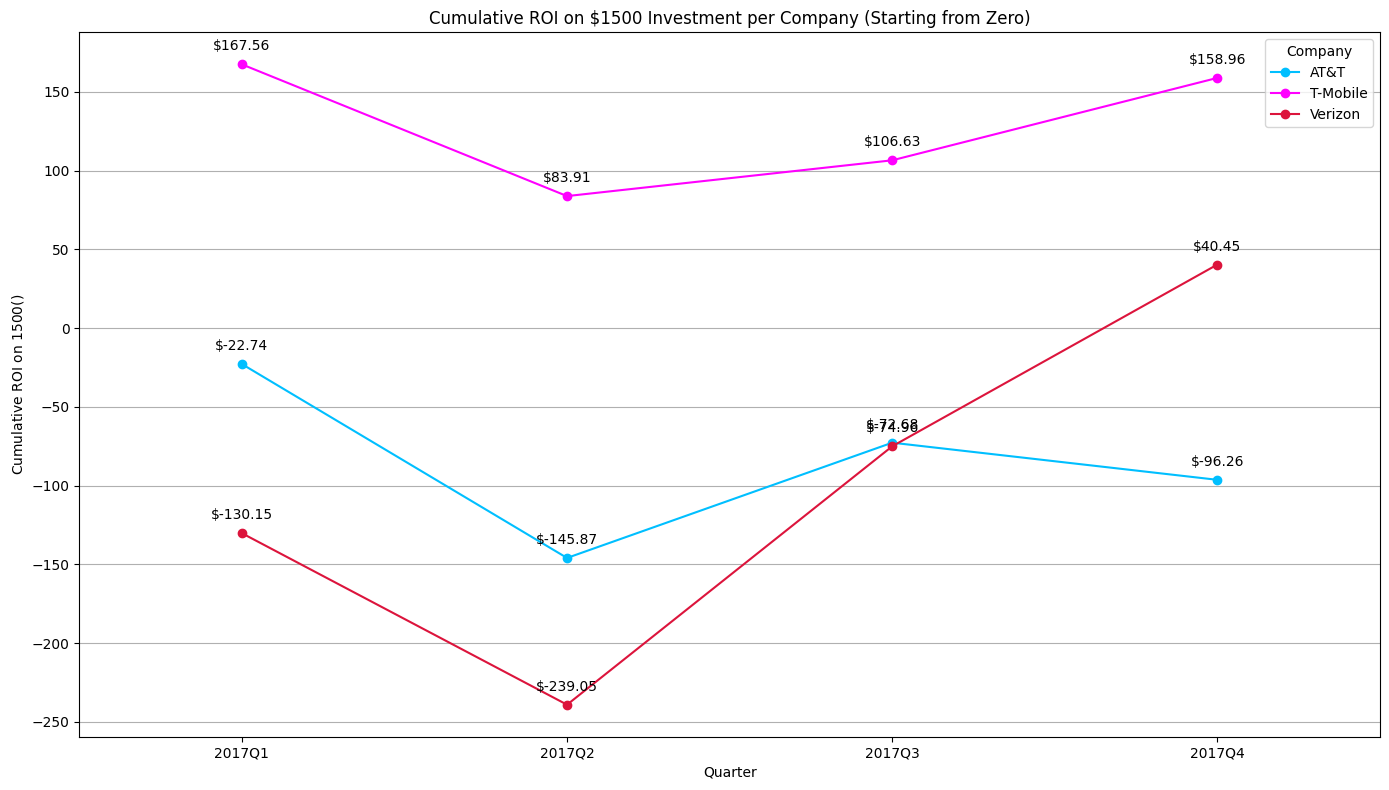

In [16]:
# Get the opening price on 2017-01-03 for each company
initial_prices_tele = filtered_tele_data[filtered_tele_data['Date'] == pd.Timestamp('2017-01-03')].set_index('Company')['Adj. Open']

# Calculate the ROI based on quarter opening and closing prices of the tele Stocks Data
def tele_roi(group):
    opening_price = group.iloc[0]['Adj. Open']
    closing_price = group.iloc[-1]['Adj. Close']
    roi_percentage = ((closing_price - opening_price) / opening_price) * 100
    return pd.Series({
        'Quarter ROI (%)': roi_percentage,
        'ROI on $1500 ($)': (roi_percentage / 100) * 1500
    })

# Apply the ROI calculation to each company for each quarter
quarterly_tele_roi = filtered_tele_data.groupby(['Company', 'Quarter']).apply(tele_roi).reset_index()

# Initialize cumulative ROI with zero
initial_investment = pd.DataFrame({
    'Company': initial_prices.index,
    'Quarter': '0',
    'Quarter ROI (%)': 0,
    'ROI on $1500 ($)': 0,
    'Cumulative ROI on $1500 ($)': 0
})

# Ensure that the cumulative ROI starts from zero for each company
quarterly_tele_roi['Cumulative ROI on $1500 ($)'] = quarterly_tele_roi.groupby('Company')['ROI on $1500 ($)'].cumsum()
quarterly_tele_roi = pd.concat([initial_investment, quarterly_tele_roi], ignore_index=True).sort_values(by=['Company', 'Quarter'])

# Convert the 'Quarter' column to string
quarterly_tele_roi['Quarter'] = quarterly_tele_roi['Quarter'].astype(str)

# Remove the final zero point at the end for each company
quarterly_tele_roi = quarterly_tele_roi[quarterly_tele_roi['Quarter'] != '0']

# Plot the cumulative ROI on a $1500 investment starting from zero
plt.figure(figsize=(14, 8))

for company in quarterly_tele_roi['Company'].unique():
    company_data = quarterly_tele_roi[quarterly_tele_roi['Company'] == company]
    plt.plot(company_data['Quarter'].astype(str), company_data['Cumulative ROI on $1500 ($)'], marker='o', label=company, color=tele_colors[company])

    # Annotate each point with the Y value
    for i, row in company_data.iterrows():
        plt.annotate(f"${row['Cumulative ROI on $1500 ($)']:.2f}", (row['Quarter'], row['Cumulative ROI on $1500 ($)']), textcoords="offset points",
                         xytext=(0, 10), ha='center')

# Plot visual formatting.
# Define the x-tick positions and labels
xticks_positions = range(len(quarterly_tele_roi['Quarter'].unique()))
xticks_labels = ['2017Q1', '2017Q2', '2017Q3', '2017Q4']

plt.xticks(xticks_positions, xticks_labels)

# Set x-axis limits to include space before the first quarter
plt.xlim(left=-0.5, right=len(xticks_positions)-0.5)

plt.title('Cumulative ROI on $1500 Investment per Company (Starting from Zero)')
plt.xlabel('Quarter')
plt.ylabel('Cumulative ROI on $1500 ($)')
plt.legend(title='Company')
plt.grid(True, axis='y')  # Horizontal grid lines only
plt.tight_layout()
plt.savefig('outputs/tele_roi.png')
plt.show()

## Industry Analysis

## Comparison of results

### Test